In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from bayes import logPr_bayes, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()

In [2]:
def middle_logX_like():
    def func(logX, theta):
        d, sigma = theta
        X = np.exp(logX)
        return -X**(2/d)/(2*sigma**2)
    def inverse(logL, theta):
        d, sigma = theta
        return np.log((-2*sigma**2 * logL)**(d/2))
    def prime(logX, theta):
        d, sigma = theta
        X = np.exp(logX)
        return - 1/(d*sigma**2) * X**(2/d)
    return likelihood(func, inverse, prime)
middle_logX = middle_logX_like()

In [3]:
def simple_logX_like():
    def func(logX, d):
        X = np.exp(logX)
        return -X**(2/d)
    def inverse(logL, d):
        return np.log((-logL)**(d/2))
    def prime(logX, d):
        X = np.exp(logX)
        return - (2/d) * X**(2/d)
    return likelihood(func, inverse, prime)
simple_logX = simple_logX_like()


def compare_bayes_ls_logX(nk, theta_true, likelihood, mean, covinv, repeats=10, log=False):
    repeats = 10
    bs = np.zeros((repeats, len(theta_true)))
    ls = np.zeros((repeats, len(theta_true)))
    for i in range(repeats):
        Xs = generate_Xs(nk)
        logXs = np.log(Xs)
        y = likelihood.func(logXs, theta_true)
        bs[i] = minimise_bayes(y, likelihood, mean, covinv, theta_true).x
        ls[i] = minimise_ls(y, likelihood, mean, theta_true).x
    print(f"Bayes: {bs.mean(axis=0)} +/- {bs.std(axis=0)}")
    print(f"LS: {ls.mean(axis=0)} +/- {ls.std(axis=0)}")

In [4]:
nk = 500 * np.ones(1000)
# nk = data_at_iteration(samples_g_1, 1000)[0]
mean_logX = logX_mu(nk)
covinv_logX = logX_covinv_chol(nk)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)

### Simple

In [5]:
theta_true = np.array([10])
compare_bayes_ls_logX(nk, theta_true, simple_logX, mean_logX, covinv_logX, repeats=10, log=True)

Bayes: [10.00636862] +/- [0.30373341]
LS: [10.08423753] +/- [0.23150242]


bayes: [10.06476682]
ls: [10.24569499]


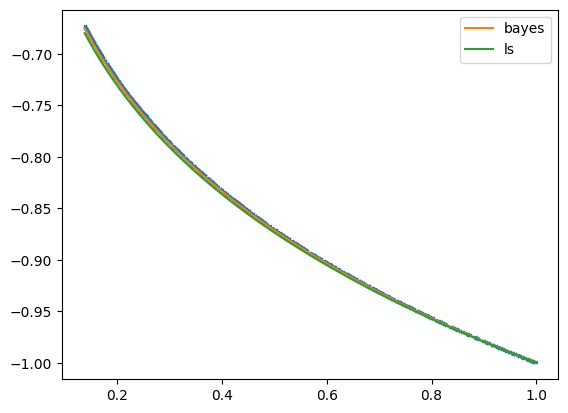

In [6]:
Xs = generate_Xs(nk)
logXs = np.log(Xs)
y = simple_logX.func(logXs, theta_true)

theta_bayes = minimise_bayes(y, simple_logX, mean_logX, covinv_logX, theta_true).x
theta_ls = minimise_ls(y, simple_logX, mean_logX, theta_true).x

plt.plot(Xs, y, 'x', ms=2)
plt.plot(Xs, simple.func(Xs, theta_bayes), label='bayes')
plt.plot(Xs, simple.func(Xs, theta_ls), label='ls')
plt.legend();
print(f'bayes: {theta_bayes}')
print(f'ls: {theta_ls}')

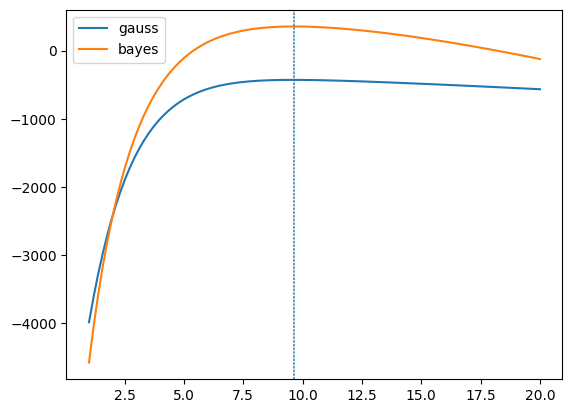

In [7]:
dtrue = 10
Xs = generate_Xs(nk)
y = simple.func(Xs, dtrue)

ds = np.linspace(1, 20, 100)
logprs_gaussian = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_gaussian[i] = logPr_gaussian(y, simple, mean_X, covinv_X, d)
d_gauss = minimise_gaussian(y, simple, mean_X, covinv_X, 10).x

logprs_bayes = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_bayes[i] = logPr_bayes(y, simple, mean_X, covinv_X, d)
d_bayes = minimise_bayes(y, simple, mean_X, covinv_X, 10).x

plt.plot(ds, logprs_gaussian, label='gauss')
plt.axvline(x=d_gauss, ls='--', lw=.5)
plt.plot(ds, logprs_bayes, label='bayes')
plt.axvline(x=d_bayes, ls='--', lw=.5)
plt.legend();

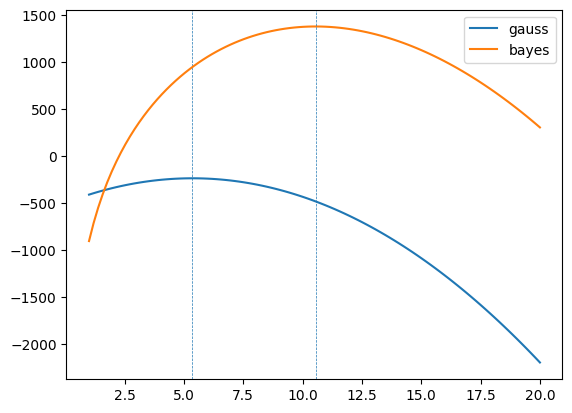

In [8]:
dtrue = 10
Xs = generate_Xs(nk)
logXs = np.log(Xs)
y = simple_logX.func(logXs, dtrue)

ds = np.linspace(1, 20, 100)
logprs_gaussian = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_gaussian[i] = logPr_gaussian(y, simple_logX, mean_logX, covinv_logX, d)
d_gauss = minimise_gaussian(y, simple_logX, mean_logX, covinv_logX, 10).x

logprs_bayes = np.zeros_like(ds)
for i, d in enumerate(ds):
    logprs_bayes[i] = logPr_bayes(y, simple_logX, mean_logX, covinv_logX, d)
d_bayes = minimise_bayes(y, simple_logX, mean_logX, covinv_logX, 10).x

plt.plot(ds, logprs_gaussian, label='gauss')
plt.axvline(x=d_gauss, ls='--', lw=.5)
plt.plot(ds, logprs_bayes, label='bayes')
plt.axvline(x=d_bayes, ls='--', lw=.5)
plt.legend();

### Middle

In [9]:
theta_true = np.array([10, 0.1])
compare_bayes_ls_logX(nk, theta_true, middle_logX, mean_logX, covinv_logX, repeats=10, log=True)

Bayes: [9.95662404 0.09999582] +/- [2.85365231e-01 1.52027201e-05]
LS: [9.84985322 0.09996326] +/- [1.13746855e-01 1.02579862e-04]


bayes: [9.69306126 0.10001234]
ls: [9.90196427 0.09956244]


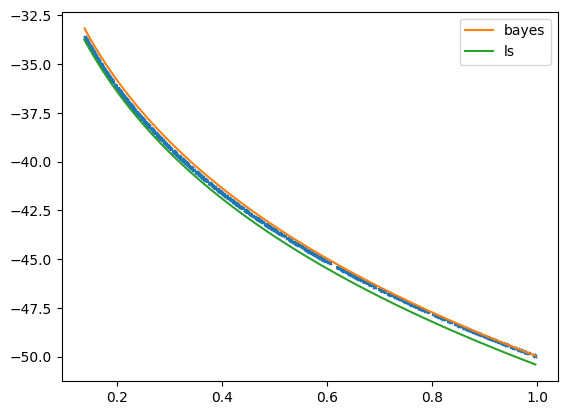

In [11]:
Xs = generate_Xs(nk)
logXs = np.log(Xs)
y = middle_logX.func(logXs, theta_true)

theta_bayes = minimise_bayes(y, middle_logX, mean_logX, covinv_logX, theta_true).x
theta_ls = minimise_ls(y, middle_logX, mean_logX, theta_true).x

plt.plot(Xs, y, 'x', ms=2)
plt.plot(Xs, middle.func(Xs, theta_bayes), label='bayes')
plt.plot(Xs, middle.func(Xs, theta_ls), label='ls')
plt.legend();
print(f'bayes: {theta_bayes}')
print(f'ls: {theta_ls}')

In [88]:
def target_X(theta):
    from scipy.special import gamma
    d, sigma = theta
    return 2**(d/2) * sigma**d * gamma(1 + d/2)

def Ltarget_theta(theta_true, theta_predicted):
    return abs(target_X(theta_true) - target_X(theta_predicted))
    
b = 0
l = 0
theta_true = np.array([10, 0.1])
for i in range(100):
    Xs = generate_Xs(nk)
    logXs = np.log(Xs)
    y = middle_logX.func(logXs, theta_true)
    theta_b =  minimise_bayes(y, middle_logX, mean_logX, covinv_logX, theta_true).x
    theta_l = minimise_ls(y, middle_logX, mean_logX, theta_true).x
    if Ltarget_theta(theta_true, theta_b) < Ltarget_theta(theta_true, theta_l):
        b += 1
    else:
        l += 1
    if (i % 5) == 0:
        print(f'{i}: bayes {b}, ls {l}')
print(f'{i}: bayes {b}, ls {l}')

0: bayes 0, ls 1
5: bayes 3, ls 3
10: bayes 8, ls 3
15: bayes 10, ls 6
20: bayes 13, ls 8
25: bayes 13, ls 13
30: bayes 14, ls 17
35: bayes 17, ls 19
40: bayes 20, ls 21
45: bayes 23, ls 23
50: bayes 25, ls 26
55: bayes 27, ls 29
60: bayes 28, ls 33
65: bayes 30, ls 36
70: bayes 33, ls 38
75: bayes 37, ls 39
80: bayes 40, ls 41
85: bayes 42, ls 44
90: bayes 44, ls 47
95: bayes 47, ls 49
99: bayes 49, ls 51
